# Word2Vec 분석

Word2Vec은 어떤 단어와 단어 사이의 의미 거리를 Vector로 표현한 것이라고 볼 수 있다. 당연하게도 Vector는 합산이 가능하며, 그를 통해 단어와 단어의 거리 뿐만 아니라 문서와 문서의 거리도 구할 수 있다.

<br><br>

이 문서와 문서 간의 의미의 거리는 컴퓨터의 평점으로 계산된 거리와는 또 다른 통찰을 가져다 줄 것으로 추측했다.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()
sns.set_context('talk')

try:
    font_location = "HANDotum.ttf"
    font_name = fm.FontProperties(fname = font_location).get_name()
    matplotlib.rc('font', family=font_name)
except:
    print("폰트 임포트 에러")

In [2]:
rv1 = pd.read_csv("Data/review1_idx.csv", encoding="cp949", index_col=[0])
# 1개만 리뷰한 유저들 drop
review_grouped_by_user = rv1.groupby(["Author"])

user_group = review_grouped_by_user.groups
user_1_rv = []
for user in user_group.keys() :
    if len(user_group[user]) == 1 :
        user_1_rv.append(user)
len(user_1_rv)

rv1 = rv1[~rv1["Author"].isin(user_1_rv)]
rv1

,Title,ConRate,DesRate,Author,Date,Content,BookCode
0,"당신의 인생을 정리해드립니다, 내 인생도 정리해보자",5,5,lazyass,2020/10/06,저는 물욕 많고 버릴 줄 모르는 사람이에요. 게다가 정리를 잘 할줄 모르니 어떤 상...,9.791170e+12
2,당신의 인생을 정리해드립니다 #가정살림,5,5,책읽는샘,2020/10/06,2020-145 <당신의 인생을 정리해드립니다(이지영 지음/쌤앤파커스)> #가정살림...,9.791170e+12
3,[가정살림] 당신의 인생을 정리해드립니다,5,4,지훈러브,2020/10/06,싱글일때는 나름 깨끗하게 정리를 잘했다고 생각했는데?아이가 태어나고?아이 용품이 늘...,9.791170e+12
4,당신의 인생을 정리해드립니다,5,5,qaz1189,2020/10/06,"예전에는 아이들을 모두 어린이집, 유치원에 등원시키고 사부작사부작 거리면서 하나하나...",9.791170e+12
5,"당신의 인생을 정리해드립니다, 이지영, 쌤앤파커스",5,5,박공주,2020/10/06,당신의 인생을 정리해드립니다.'? 저자는 당신의 '집'이 아닌 '인생'을 정리하겠다...,9.791170e+12
...,...,...,...,...,...,...,...
26476,따뜻한 반전동화! [강아지 항공사에 찾아온 무시무시한 손님],5,5,lunar1982,2020/04/02,요즘처럼 전국민이 여행에 목말라있는 때가 있었을까 싶을까요?여행의 설렘이 늘 함께하...,9.788970e+12
26478,강아지 항공사에 찾아온 무시무시한 손님 / 귀엽고 따뜻한 그림책이에요,5,5,spqcu,2020/03/31,아이들이 크면 그림책을 안볼 줄 알았는데요특히 저희 둘째는 그림그리기를 좋아해서인지...,9.788970e+12
26479,"대 반전 그림책, 강아지 항공사에 찾아온 무시무시한 손님",5,5,리프,2020/03/31,허웅 ㅠㅠ 너무 귀여워요 ㅠㅠ 어떡해 ㅠㅠ표지부터 완전 심쿵! 세젤귀 강아지들이 오...,9.788970e+12
26481,마로네랑 쿠키,5,5,pyr1218,2020/10/06,모카랑 핫초코 책과 함께 구매했는데 책이 너무 작은 사이즈라서 받아보고 놀랐고 제 ...,9.791190e+12


In [2]:
import MeCab
import re

def pos_mecab(sentence) :
    """

    :param sentence:
    :return:
    """
    m = MeCab.Tagger()

    # 저\tNP,*,F,저,Inflect,NP,NP,제/NP/*
    out = m.parse(sentence)

    sentences = out.split('\n')
    p = re.compile('(.*)\t(.*),(.*),(.*),(.*),(.*),(.*),(.*),(.*)')
    sentences = [p.findall(s) for s in sentences]

    tags = []
    for s in sentences :
        if len(s) > 0 and len(s[0]) > 0 :
            s = s[0]
            tags.append((s[0], s[1]))
    return tags

pos_mecab(rv1["Content"][0])

NameError: name 'rv1' is not defined

## 리뷰 텍스트에서 구한 Word2Vec으로 해보기

### 모델 구축
먼저 리뷰 텍스트에서 Word2Vec을 구한 후에 모델에 적용해 보기로 한다.

In [4]:
rv1 = rv1[~rv1["Content"].isnull()]

In [5]:
result = []
for con in rv1["Content"]:
    sen = con.split('.')
    sen = [s.strip() for s in sen if s.strip() != '']
    
    for s in sen :
        tag = pos_mecab(s)
        tag = [t[0].strip() for t in tag if t[1][0] != 'S']
        
        result.append(tag)

len(result)

476565

In [6]:
from gensim.models import Word2Vec
rv_model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

In [45]:
rv_model.most_similar('상상')

[('착각', 0.48839378356933594),
 ('생각', 0.4812341034412384),
 ('즐거워하', 0.47967398166656494),
 ('경험', 0.47305458784103394),
 ('망상', 0.4660475254058838),
 ('초월', 0.4562140107154846),
 ('예상', 0.4553142189979553),
 ('감탄', 0.4543972611427307),
 ('상상도', 0.44329705834388733),
 ('떠올리', 0.4299180507659912)]

In [20]:
rv_model.wv.save_word2vec_format('bookrv_w2v')

모델 구축 완료

---

### 문서 벡터의 길이를 이용한 방법

In [42]:
from gensim.models import KeyedVectors
rv_model = KeyedVectors.load_word2vec_format('bookrv_w2v')

In [60]:
rv_model.most_similar('상상')

[('착각', 0.48839378356933594),
 ('생각', 0.4812341034412384),
 ('즐거워하', 0.47967398166656494),
 ('경험', 0.47305458784103394),
 ('망상', 0.4660475254058838),
 ('초월', 0.4562140107154846),
 ('예상', 0.4553142189979553),
 ('감탄', 0.4543972611427307),
 ('상상도', 0.44329705834388733),
 ('떠올리', 0.4299180507659912)]

In [63]:
# 문서 벡터의 크기(magnitude) 구하기
doc_len = []
for con in rv1["Content"]:
    sen = con.split('.')
    sen = [s.strip() for s in sen if s.strip() != '']
    words = []
    
    for s in sen:
        tag = pos_mecab(s)
        tag = [t[0].strip() for t in tag if t[1][0] != 'S']
        
        words.extend(tag)
    
    doc_vec = np.zeros((100))
    for w in words:
        if w in rv_model.vocab:
            doc_vec += rv_model.get_vector(w)
    
    doc_len.append(np.sqrt(doc_vec.dot(doc_vec)))

doc_len[:10]

[3313.0737510624067,
 4746.308343485822,
 4999.028551725655,
 4532.811448483444,
 6483.601900880666,
 2807.6715160262984,
 4383.455398465433,
 5139.336448675975,
 4522.712773933237,
 5268.843169243814]

In [64]:
rv1["ContentMagnitude"] = doc_len
rv1["ContentMagnitude"].describe()

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


count    19049.000000
mean      2582.398117
std       2373.744250
min          0.000000
25%        791.859556
50%       2077.306428
75%       3254.726092
max      29568.598808
Name: ContentMagnitude, dtype: float64

문서 벡터의 크기라는 속성은 리뷰의 길이의 영향을 많이 받고, 리뷰의 의미의 영향을 약하게 받을 것으로 예상된다.

In [65]:
rv1[rv1["ContentMagnitude"] == 0]

,Title,ConRate,DesRate,Author,Date,Content,BookCode,ContentMagnitude
1935,Good,5,5,Michael,2019/10/21,The importance of reading can be emphasized ma...,9.791200e+12,0.0
8116,I recommend this book.,4,4,Michael,2020/01/27,This book is good for young people in Korea. W...,9.788940e+12,0.0
12423,숨마쿰라우데 스타트업 중학수학 1-상 1525제,5,5,ener2000,2019/01/20,.................................................,9.788960e+12,0.0
17448,인간의 130가지 감정 표현법,5,5,롤롤롤,2020/09/29,#NAME?,9.791190e+12,0.0


c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '빈도수')

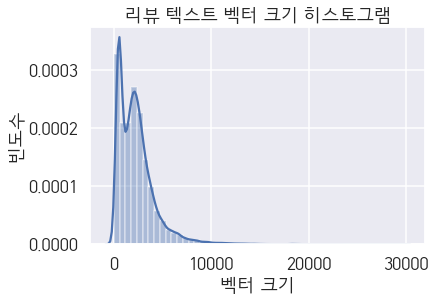

In [5]:
sns.distplot(rv1["ContentMagnitude"])
plt.title("리뷰 텍스트 벡터 크기 히스토그램")
plt.xlabel("벡터 크기")
plt.ylabel("빈도수")

In [74]:
rv1["RateSum"] = rv1["ConRate"] + rv1["DesRate"]

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


구한 값을 파일로 저장했다.
#### 유사도 벡터 테이블 구성하기

In [2]:
rv1 = pd.read_csv("Data/review1_pre.csv", index_col=[0])
rv1

,Title,ConRate,DesRate,Author,Date,Content,BookCode,ContentMagnitude,SumRate
0,"당신의 인생을 정리해드립니다, 내 인생도 정리해보자",5,5,lazyass,2020-10-06,저는 물욕 많고 버릴 줄 모르는 사람이에요. 게다가 정리를 잘 할줄 모르니 어떤 상...,9.791165e+12,3313.073751,10
2,당신의 인생을 정리해드립니다 #가정살림,5,5,책읽는샘,2020-10-06,2020-145 <당신의 인생을 정리해드립니다(이지영 지음/쌤앤파커스)> #가정살림...,9.791165e+12,4746.308343,10
3,[가정살림] 당신의 인생을 정리해드립니다,5,4,지훈러브,2020-10-06,싱글일때는 나름 깨끗하게 정리를 잘했다고 생각했는데 아이가 태어나고 아이 용품이 늘...,9.791165e+12,4999.028552,9
4,당신의 인생을 정리해드립니다,5,5,qaz1189,2020-10-06,"예전에는 아이들을 모두 어린이집, 유치원에 등원시키고 사부작사부작 거리면서 하나하나...",9.791165e+12,4532.811448,10
5,"당신의 인생을 정리해드립니다, 이지영, 쌤앤파커스",5,5,박공주,2020-10-06,'당신의 인생을 정리해드립니다.' 저자는 당신의 '집'이 아닌 '인생'을 정리하겠...,9.791165e+12,6483.601901,10
...,...,...,...,...,...,...,...,...,...
26476,따뜻한 반전동화! [강아지 항공사에 찾아온 무시무시한 손님],5,5,lunar1982,2020-04-02,요즘처럼 전국민이 여행에 목말라있는 때가 있었을까 싶을까요?여행의 설렘이 늘 함께하...,9.788965e+12,1748.713176,10
26478,강아지 항공사에 찾아온 무시무시한 손님 / 귀엽고 따뜻한 그림책이에요,5,5,spqcu,2020-03-31,아이들이 크면 그림책을 안볼 줄 알았는데요특히 저희 둘째는 그림그리기를 좋아해서인지...,9.788965e+12,1161.610239,10
26479,"대 반전 그림책, 강아지 항공사에 찾아온 무시무시한 손님",5,5,리프,2020-03-31,허웅 ㅠㅠ 너무 귀여워요 ㅠㅠ 어떡해 ㅠㅠ표지부터 완전 심쿵! 세젤귀 강아지들이 오...,9.788965e+12,1179.810356,10
26481,마로네랑 쿠키,5,5,pyr1218,2020-10-06,모카랑 핫초코 책과 함께 구매했는데 책이 너무 작은 사이즈라서 받아보고 놀랐고 제 ...,9.791189e+12,505.367699,10


In [3]:
# 중복된 리뷰 삭제하기
rv1 = rv1.drop_duplicates(['Author', 'BookCode'], keep='first')
rv1

,Title,ConRate,DesRate,Author,Date,Content,BookCode,ContentMagnitude,SumRate
0,"당신의 인생을 정리해드립니다, 내 인생도 정리해보자",5,5,lazyass,2020-10-06,저는 물욕 많고 버릴 줄 모르는 사람이에요. 게다가 정리를 잘 할줄 모르니 어떤 상...,9.791165e+12,3313.073751,10
2,당신의 인생을 정리해드립니다 #가정살림,5,5,책읽는샘,2020-10-06,2020-145 <당신의 인생을 정리해드립니다(이지영 지음/쌤앤파커스)> #가정살림...,9.791165e+12,4746.308343,10
3,[가정살림] 당신의 인생을 정리해드립니다,5,4,지훈러브,2020-10-06,싱글일때는 나름 깨끗하게 정리를 잘했다고 생각했는데 아이가 태어나고 아이 용품이 늘...,9.791165e+12,4999.028552,9
4,당신의 인생을 정리해드립니다,5,5,qaz1189,2020-10-06,"예전에는 아이들을 모두 어린이집, 유치원에 등원시키고 사부작사부작 거리면서 하나하나...",9.791165e+12,4532.811448,10
5,"당신의 인생을 정리해드립니다, 이지영, 쌤앤파커스",5,5,박공주,2020-10-06,'당신의 인생을 정리해드립니다.' 저자는 당신의 '집'이 아닌 '인생'을 정리하겠...,9.791165e+12,6483.601901,10
...,...,...,...,...,...,...,...,...,...
26476,따뜻한 반전동화! [강아지 항공사에 찾아온 무시무시한 손님],5,5,lunar1982,2020-04-02,요즘처럼 전국민이 여행에 목말라있는 때가 있었을까 싶을까요?여행의 설렘이 늘 함께하...,9.788965e+12,1748.713176,10
26478,강아지 항공사에 찾아온 무시무시한 손님 / 귀엽고 따뜻한 그림책이에요,5,5,spqcu,2020-03-31,아이들이 크면 그림책을 안볼 줄 알았는데요특히 저희 둘째는 그림그리기를 좋아해서인지...,9.788965e+12,1161.610239,10
26479,"대 반전 그림책, 강아지 항공사에 찾아온 무시무시한 손님",5,5,리프,2020-03-31,허웅 ㅠㅠ 너무 귀여워요 ㅠㅠ 어떡해 ㅠㅠ표지부터 완전 심쿵! 세젤귀 강아지들이 오...,9.788965e+12,1179.810356,10
26481,마로네랑 쿠키,5,5,pyr1218,2020-10-06,모카랑 핫초코 책과 함께 구매했는데 책이 너무 작은 사이즈라서 받아보고 놀랐고 제 ...,9.791189e+12,505.367699,10


In [4]:
rv1 = rv1[~pd.isna(rv1["Author"])]

In [22]:
from scipy import sparse
rv_book_pivot = rv1.pivot(index='Author', columns='BookCode', values='SumRate')
rv_book_pivot = rv_book_pivot.fillna(0)
rv_list = rv_book_pivot.index
book_list = rv_book_pivot.columns
rv_book_pivot = sparse.csr_matrix(rv_book_pivot)

In [7]:
for i in rv1.index:
    author = rv1.loc[i, 'Author']
    isbn = rv1.loc[i, 'BookCode']
    mag = rv1.loc[i, 'ContentMagnitude']
    # 벡터 크기 / 100 만큼 rating에 합산
    rv_book_pivot.loc[author, isbn] = rv_book_pivot.loc[author, isbn] + mag / 10

rv_book_pivot

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
히야신스,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
히이이익,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [8]:
# 코사인 유사도
def cos_sim(A, B):
    return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))

In [9]:
book_rv_pivot = rv_book_pivot.T
book_rv_pivot

Author,'_'*,**01 22 2020 9:45PM**,**09 4 2018 1:15PM**,**09 12 2017 10:14AM**,**10 27 2017 4:24PM**,**12 2 2016 10:03PM**,-,0001007,00jyk0903,00sw,...,희망직장인,희선,희스토리,흰나비,히가시노,히또리도리돌,히야신스,히이이익,히키,힘찬발걸음
BookCode,,,,,,,,,,,,,,,,,,,,,
8.801748e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8.809124e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8.809255e+12,0.0,0.0,0.0,0.0,0.0,0.0,60.013964,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8.809255e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8.809264e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.791197e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9.791197e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9.791197e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [10]:
book_num = book_rv_pivot.shape[0]
book_sim_table = np.zeros((book_num, book_num))
book_sim_table = pd.DataFrame(book_sim_table, index=book_rv_pivot.index, columns=book_rv_pivot.index)
book_sim_table

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
BookCode,,,,,,,,,,,,,,,,,,,,,
8.801748e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.809124e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.809255e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.809255e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.809264e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.791197e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.791197e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.791197e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
cos_sim(np.array(book_rv_pivot.loc[9791165342333,]), np.array(book_rv_pivot.loc[9791136248787,]))

0.05227641034818338

In [12]:
for i in book_rv_pivot.index:
    for j in book_rv_pivot.index:
        sim = cos_sim(np.array(book_rv_pivot.loc[i,]), np.array(book_rv_pivot.loc[j,]))
        book_sim_table.loc[i, j] = sim

book_sim_table

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
BookCode,,,,,,,,,,,,,,,,,,,,,
8.801748e+12,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8.809124e+12,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.142924
8.809255e+12,0.0,0.000000,1.000000,0.711773,0.0,0.0,0.0,0.0,0.0,0.0,...,0.130142,0.0,0.000000,0.0,0.171112,0.000000,0.000000,0.0,0.000000,0.000000
8.809255e+12,0.0,0.000000,0.711773,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8.809264e+12,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.791197e+12,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.011587,0.0,0.000000,0.000000
9.791197e+12,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.011587,1.000000,0.0,0.000000,0.000000
9.791197e+12,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000


word2vec의 텍스트 벡터가 유사도에 별 영향을 주지 못하면서, 추가적인 정보를 제공하는 것이 아니라 유사도를 떨어뜨리는 방향으로만 작용하는 것으로 보였다. 이를 검증하고자 한다.

In [13]:
rv_book_pivot = rv1.pivot(index='Author', columns='BookCode', values='SumRate')
rv_book_pivot = rv_book_pivot.fillna(0)
rv_book_pivot

book_rv_pivot = rv_book_pivot.T
book_rv_pivot

book_sim_table_rate = np.zeros((book_num, book_num))
book_sim_table_rate = pd.DataFrame(book_sim_table_rate, index=book_rv_pivot.index, columns=book_rv_pivot.index)
book_sim_table_rate

for i in book_rv_pivot.index:
    for j in book_rv_pivot.index:
        sim = cos_sim(np.array(book_rv_pivot.loc[i,]), np.array(book_rv_pivot.loc[j,]))
        book_sim_table_rate.loc[i, j] = sim

book_sim_table_rate

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
BookCode,,,,,,,,,,,,,,,,,,,,,
8.801748e+12,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8.809124e+12,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.070646
8.809255e+12,0.0,0.000000,1.000000,0.728219,0.0,0.0,0.0,0.0,0.0,0.0,...,0.201619,0.0,0.000000,0.0,0.258199,0.000000,0.000000,0.0,0.000000,0.000000
8.809255e+12,0.0,0.000000,0.728219,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8.809264e+12,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.791197e+12,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.162586,0.0,0.000000,0.000000
9.791197e+12,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.162586,1.000000,0.0,0.000000,0.000000
9.791197e+12,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000


-0.7194712203164457 0.6679362485069104


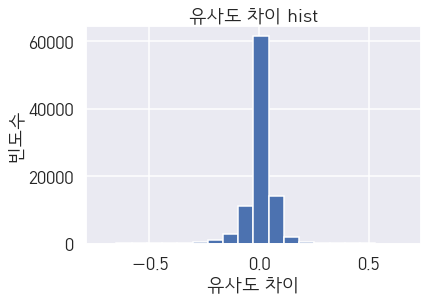

In [30]:
# 두 유사도 수치의 차이를 구하고, 0이 아닌 값만 추출
sim_diff = book_sim_table_rate.values - book_sim_table.values
sim_diff_non_zero = sim_diff[sim_diff != 0]

plt.hist(sim_diff_non_zero, bins=20)
plt.title("유사도 차이 hist")
plt.xlabel("유사도 차이")
plt.ylabel("빈도수")
print(min(sim_diff_non_zero), max(sim_diff_non_zero))

대부분의 수치는 0.0 주변에 있었으나, 몇몇 유사도 자체에 차이를 가져올 정도의 차이를 내는 경우도 있었다.
처음 가설로 세웠던 것처럼 일방적으로 유사도를 낮추는 효과만 있는 것은 아니었다.
다만, 얼마나 새로운 정보를 제공했는지에 대해 새로이 살펴보아야 한다.
### 모델 평가
모델의 평가는 F-1 점수와 MAE로 이루어질 수 있다.

In [4]:
# 유사도 테이블 로드
sim_mag = pd.read_csv("Data/sim_mag.csv", index_col=[0])
sim_norm = pd.read_csv("Data/sim_normal.csv", index_col=[0])

In [9]:
# 상위 10개의 근접 이웃 찾기
def get_nearest_books(sim, isbn, n=10) :
    n_book = sim.loc[isbn, :].sort_values(ascending=False)[:10]
    return n_book

book_isbn = 9791127856823.0
get_nearest_books(sim_mag, book_isbn)

9791127856823.0           1.000000
9791127856854.0           0.552079
9791164596362.0           0.240647
9788965422754.0           0.136473
9788965422631.0           0.041113
1.8446744073709552e+19    0.009168
9788984118607.0           0.000000
9788983799258.0           0.000000
9788980400850.0           0.000000
9788980815555.0           0.000000
Name: 9791127856823.0, dtype: float64

In [3]:
# 피봇 테이블 만들기
rv1 = pd.read_csv("Data/review1_pre.csv", index_col=[0])
rv1 = rv1.drop_duplicates(['Author', 'BookCode'], keep='first')
rv1 = rv1[~pd.isna(rv1["Author"])]

rv_book_pivot = rv1.pivot(index='Author', columns='BookCode', values='SumRate')
rv_book_pivot = rv_book_pivot.fillna(0)
us_list = rv_book_pivot.index
book_list = rv_book_pivot.columns

book_rv_pivot = rv_book_pivot.T
book_rv_pivot

Author,'_'*,**01 22 2020 9:45PM**,**09 4 2018 1:15PM**,**09 12 2017 10:14AM**,**10 27 2017 4:24PM**,**12 2 2016 10:03PM**,-,0001007,00jyk0903,00sw,...,희망직장인,희선,희스토리,흰나비,히가시노,히또리도리돌,히야신스,히이이익,히키,힘찬발걸음
BookCode,,,,,,,,,,,,,,,,,,,,,
8.801748e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.809124e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.809255e+12,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.809255e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.809264e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.791197e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.791197e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.791197e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 근접 이웃한 유저 찾기, 유저-책 점수 행렬이 만들어져 있어야 한다.
# NN 모델 만들기
from sklearn import neighbors
nn_model = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
nn_model.fit(book_rv_pivot)
sim, idx = nn_model.kneighbors(book_rv_pivot)

In [34]:
sim[2], idx[2]

(array([1.11022302e-16, 1.92427147e-01, 1.94476905e-01, 2.38595864e-01,
        2.71780919e-01, 7.13554050e-01, 7.41801110e-01, 7.41801110e-01,
        7.41801110e-01, 7.41801110e-01]),
 array([   2,  936,  934,  935,    3, 1382, 1419,  138,  616,  937],
       dtype=int64))

In [7]:
val = np.zeros(rv_book_pivot.shape)
predicted_scores = pd.DataFrame(val, index=us_list, columns=book_list)
k = 10

for i in range(predicted_scores.shape[0]):
    cur_user = us_list[i]
    # 밑에 부분은 행렬로 가능할 것 같은데..
    for j in range(predicted_scores.shape[1]):
        nearest_books = book_list[idx[j][1:]]
        simmilarities = sim[j][1:]
        rv_scores = rv_book_pivot.loc[cur_user, nearest_books]
        sim_sum = simmilarities[rv_scores>0].sum()
        rate_sum = np.multiply(simmilarities, rv_scores).sum()
        predicted_scores.iloc[i, j] = 0
        if sim_sum > 0:
            predicted_scores.iloc[i, j] = rate_sum / sim_sum

predicted_scores

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,10.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.0,10.0,0.0,0.0,10.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
predicted_scores.to_csv("Data/pred_rate_norm2.csv")

---

In [2]:
predicted_scores = pd.read_csv("Data/pred_rate_norm2.csv", index_col=[0])

rv1 = pd.read_csv("Data/review1_pre.csv", index_col=[0])
rv1 = rv1.drop_duplicates(['Author', 'BookCode'], keep='first')
rv1 = rv1[~pd.isna(rv1["Author"])]

rv_book_pivot = rv1.pivot(index='Author', columns='BookCode', values='SumRate')
rv_book_pivot = rv_book_pivot.fillna(0)
us_list = rv_book_pivot.index
book_list = rv_book_pivot.columns

Text(0, 0.5, '빈도수')

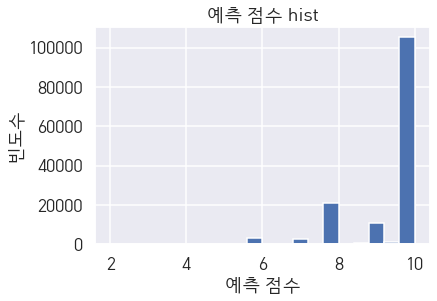

In [11]:
# 예측 점수 히스토그램
predected_scores_val = predicted_scores.values
predected_scores_val = predected_scores_val[predected_scores_val != 0]

plt.hist(predected_scores_val, bins=20)
plt.title("예측 점수 hist")
plt.xlabel("예측 점수")
plt.ylabel("빈도수")

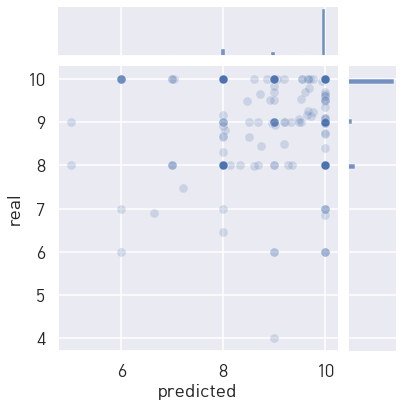

In [4]:
# 예측 점수-실제 점수 산점도
predicted_val = predicted_scores.values
real_val = rv_book_pivot.values
non_zero = (predicted_val > 0) & (real_val > 0)

predicted_real_val = np.append([predicted_val[non_zero]], [real_val[non_zero]])
predicted_real_val = predicted_real_val.reshape((-1, 2))
predicted_real_val = pd.DataFrame(predicted_real_val, columns=["predicted", "real"])

sns.jointplot(data=predicted_real_val.sample(600), x="predicted", y="real", alpha=0.2)

In [24]:
# F-1 점수 계산하기

def f1_with_rating(real_score, predicted_score, rate_threshold=8.0):
    tr = 0 # True
    tp = 0 # True Positive
    ins_num = 0 # prediction number
    rec_num = 0 # recommended number
    maprec = 0.0
    for i in range(len(real_score.columns)):
        for j in range(len(real_score.index)):
            real_rate = real_score.iloc[j, i] >= rate_threshold
            pred_rate = predicted_score.iloc[j, i] >= rate_threshold
            
            if predicted_score.iloc[j, i] > 0 :
                ins_num += 1 # 무언가를 예측한 경우에만 올라간다?
            
            if real_rate:
                tr += 1
                if pred_rate:
                    tp += 1 
            
            if pred_rate:
                rec_num += 1
                maprec += rec_num / ins_num
    
    maprec = maprec / rec_num
    recall = tp / tr
    print("MAP:{0} Recall:{1}".format(maprec, recall))
    
    f1 = 2 * maprec * recall / (maprec + recall)
    f0d5 = 1.25 * maprec * recall / (0.25 * maprec + recall)
    return f1, f0d5
    
f1_with_rating(rv_book_pivot, predicted_scores, rate_threshold=9.0)

MAP:0.7984169597225447 Recall:0.5893638751094251


(0.6781447063176069, 0.7455277728670812)

납득할만한 결과를 얻는데 성공했다.<br>
점수를 예측할 때 모든 유사도를 더하는 것이 아니라 점수가 존재하는 유사도만 더하는 것이 해결책이었다.
### 모델 비교
지금부터는 두 유사도 모델을 비교해 보려고 한다.

#### 벡터 크기 모델 점수 예측하기

In [4]:
# 벡터 길이 모델 유사도 구하기
rv1 = pd.read_csv("../Data/review1_pre.csv", index_col=[0])
rv1 = rv1.drop_duplicates(['Author', 'BookCode'], keep='first')
rv1 = rv1[~pd.isna(rv1["Author"])]

rv_book_pivot = rv1.pivot(index='Author', columns='BookCode', values='SumRate')
rv_book_pivot = rv_book_pivot.fillna(0)
us_list = rv_book_pivot.index
book_list = rv_book_pivot.columns

book_rv_pivot = rv_book_pivot.T

for i in rv1.index:
    author = rv1.loc[i, 'Author']
    isbn = rv1.loc[i, 'BookCode']
    mag = rv1.loc[i, 'ContentMagnitude']
    # 벡터 크기 / 100 만큼 rating에 합산
    book_rv_pivot.loc[isbn, author] = book_rv_pivot.loc[isbn, author] + mag / 100

In [4]:
from sklearn import neighbors
nn_model = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
nn_model.fit(book_rv_pivot)
sim, idx = nn_model.kneighbors(book_rv_pivot)

In [11]:
# 새로 피봇 테이블 구성하여 원래 점수를 가져온다.
rv_book_pivot = rv1.pivot(index='Author', columns='BookCode', values='SumRate')
rv_book_pivot = rv_book_pivot.fillna(0)

val = np.zeros(rv_book_pivot.shape)
predicted_scores = pd.DataFrame(val, index=us_list, columns=book_list)
k = 10

for i in range(predicted_scores.shape[0]):
    cur_user = us_list[i]
    # 밑에 부분은 행렬로 가능할 것 같은데..
    for j in range(predicted_scores.shape[1]):
        nearest_books = book_list[idx[j][1:]]
        simmilarities = sim[j][1:]
        rv_scores = rv_book_pivot.loc[cur_user, nearest_books]
        sim_sum = simmilarities[rv_scores>0].sum()
        rate_sum = np.multiply(simmilarities, rv_scores).sum()
        predicted_scores.iloc[i, j] = 0
        if sim_sum > 0:
            predicted_scores.iloc[i, j] = rate_sum / sim_sum

predicted_scores

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,10.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히야신스,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.0,10.0,0.0,0.0,10.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
predicted_scores.to_csv("Data/pred_rate_mag.csv")

#### 예측된 점수로 평가하기

In [ ]:
predicted_scores = pd.read_csv("Data/pred_rate_mag.csv", index_col=[0])

rv1 = pd.read_csv("Data/review1_pre.csv", index_col=[0])
rv1 = rv1.drop_duplicates(['Author', 'BookCode'], keep='first')
rv1 = rv1[~pd.isna(rv1["Author"])]

rv_book_pivot = rv1.pivot(index='Author', columns='BookCode', values='SumRate')
rv_book_pivot = rv_book_pivot.fillna(0)
us_list = rv_book_pivot.index
book_list = rv_book_pivot.columns

In [13]:
def f1_with_rating(real_score, predicted_score, rate_threshold=8.0):
    tr = 0 # True
    tp = 0 # True Positive
    ins_num = 0 # prediction number
    rec_num = 0 # recommended number
    maprec = 0.0
    for i in range(len(real_score.columns)):
        for j in range(len(real_score.index)):
            real_rate = real_score.iloc[j, i] >= rate_threshold
            pred_rate = predicted_score.iloc[j, i] >= rate_threshold
            
            if predicted_score.iloc[j, i] > 0 :
                ins_num += 1 # 무언가를 예측한 경우에만 올라간다?
            
            if real_rate:
                tr += 1
                if pred_rate:
                    tp += 1 
            
            if pred_rate:
                rec_num += 1
                maprec += rec_num / ins_num
    
    maprec = maprec / rec_num
    recall = tp / tr
    print("MAP:{0} Recall:{1}".format(maprec, recall))
    
    f1 = 2 * maprec * recall / (maprec + recall)
    f0d5 = 1.25 * maprec * recall / (0.25 * maprec + recall)
    return f1, f0d5
    
f1_with_rating(rv_book_pivot, predicted_scores, rate_threshold=9.0)

MAP:0.8016286499198763 Recall:0.5240735337029472


(0.6337959829453805, 0.7248508509172251)

결과가 기존 점수 기반 유사도 방식보다 좋지 않았다.

### 리뷰간 문서 유사도를 이용한 협업 필터링

각 리뷰의 문서 벡터를 얻어 리뷰 간의 유사도를 구한다. 이것을 리뷰 점수 유사도와 조화평균하여 구한 유사도를 최종적인 책과 책 사이의 유사도로 한다.

책의 문서 벡터는 해당 책의 모든 리뷰 벡터의 평균으로 한다.

In [6]:
# 책을 순회하면서 책에 대해 리뷰 벡터의 평균을 구한다.
from gensim.models import KeyedVectors
rv_model = KeyedVectors.load_word2vec_format('../Data/bookrv_w2v')

rv1 = pd.read_csv("../Data/review1_pre.csv", index_col=[0])
rv1 = rv1.drop_duplicates(['Author', 'BookCode'], keep='first')
rv1 = rv1[~pd.isna(rv1["Author"])]

rv_book_pivot = rv1.pivot(index='Author', columns='BookCode', values='SumRate')
rv_book_pivot = rv_book_pivot.fillna(0)
us_list = rv_book_pivot.index
book_list = rv_book_pivot.columns

book_rv_pivot = rv_book_pivot.T

In [7]:
book_mat = np.zeros((1, 100))

for isbn in book_list:
    book_rv = rv1[rv1["BookCode"] == isbn]
    doc_vec = np.zeros((100))
    
    for con in book_rv["Content"]:
        sen = con.split('.')
        sen = [s.strip() for s in sen if s.strip() != '']
        words = []

        for s in sen:
            tag = pos_mecab(s)
            tag = [t[0].strip() for t in tag if t[1][0] != 'S']

            words.extend(tag)

        for w in words:
            if w in rv_model.vocab:
                doc_vec += rv_model.get_vector(w)
    
    doc_vec /= len(book_rv)
    book_mat = np.append(book_mat, [doc_vec], axis=0)

book_mat = np.delete(book_mat, 0, 0)
dp_book_mat = pd.DataFrame(book_mat, index=book_list, columns=np.arange(100))

In [8]:
from sklearn import neighbors
import scipy.sparse

nn_model = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
nn_model.fit(dp_book_mat)
book_sim_table_w2v = nn_model.kneighbors_graph(dp_book_mat, mode='distance')
scipy.sparse.save_npz('../Data/sim_w2v.npz', book_sim_table_w2v)

In [12]:
from sklearn import neighbors
nn_model = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
nn_model.fit(dp_book_mat)
sim, idx = nn_model.kneighbors(dp_book_mat)

In [15]:
val = np.zeros(rv_book_pivot.shape)
predicted_scores = pd.DataFrame(val, index=us_list, columns=book_list)
k = 10

for i in range(predicted_scores.shape[0]):
    cur_user = us_list[i]
    # 밑에 부분은 행렬로 가능할 것 같은데..
    for j in range(predicted_scores.shape[1]):
        nearest_books = book_list[idx[j][1:]]
        simmilarities = sim[j][1:]
        rv_scores = rv_book_pivot.loc[cur_user, nearest_books]
        sim_sum = simmilarities[rv_scores>0].sum()
        rate_sum = np.multiply(simmilarities, rv_scores).sum()
        predicted_scores.iloc[i, j] = 0
        if sim_sum > 0:
            predicted_scores.iloc[i, j] = rate_sum / sim_sum

predicted_scores

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,10.0,0.0,0.0,0.0,0.0,9.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
히야신스,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
def f1_with_rating(real_score, predicted_score, rate_threshold=8.0):
    tr = 0 # True
    tp = 0 # True Positive
    ins_num = 0 # prediction number
    rec_num = 0 # recommended number
    maprec = 0.0
    for i in range(len(real_score.columns)):
        for j in range(len(real_score.index)):
            real_rate = real_score.iloc[j, i] >= rate_threshold
            pred_rate = predicted_score.iloc[j, i] >= rate_threshold
            
            if predicted_score.iloc[j, i] > 0 :
                ins_num += 1 # 무언가를 예측한 경우에만 올라간다?
            
            if real_rate:
                tr += 1
                if pred_rate:
                    tp += 1 
            
            if pred_rate:
                rec_num += 1
                maprec += rec_num / ins_num
    
    maprec = maprec / rec_num
    recall = tp / tr
    print("MAP:{0} Recall:{1}".format(maprec, recall))
    
    f1 = 2 * maprec * recall / (maprec + recall)
    f0d5 = 1.25 * maprec * recall / (0.25 * maprec + recall)
    return f1, f0d5
    
f1_with_rating(rv_book_pivot, predicted_scores, rate_threshold=9.0)

MAP:0.8063761639198977 Recall:0.2842865480011672


(0.42037174925954945, 0.589758834860834)

순수 책간 리뷰 유사도만을 이용한 점수는 Recall이 상당히 낮았다.

리뷰 유사도와 평점 유사도의 평균을 낸 새 유사도를 이용한 모델의 성능을 비교해볼 것이다.

---

In [2]:
rv1 = pd.read_csv("Data/review1_pre.csv", index_col=[0])
rv1 = rv1.drop_duplicates(['Author', 'BookCode'], keep='first')
rv1 = rv1[~pd.isna(rv1["Author"])]

rv_book_pivot = rv1.pivot(index='Author', columns='BookCode', values='SumRate')
rv_book_pivot = rv_book_pivot.fillna(0)
us_list = rv_book_pivot.index
book_list = rv_book_pivot.columns

book_rv_pivot = rv_book_pivot.T

dp_book_mat = pd.read_csv("Data/book_w2v_mat.csv", index_col=[0])

In [3]:
from sklearn import neighbors
nn_model = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=80)
nn_model.fit(dp_book_mat)
sim_rvvec, idx_rvvec = nn_model.kneighbors(dp_book_mat)

nn_model.fit(book_rv_pivot)
sim_rate, idx_rate = nn_model.kneighbors(book_rv_pivot)

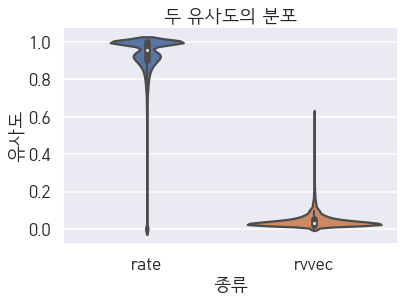

In [23]:
dp_simrate = pd.DataFrame(sim_rate.reshape(-1), columns=["sim"]) 
dp_simrate["type"] = ["rate"] * len(dp_simrate)
dp_simvec = pd.DataFrame(sim_rvvec.reshape(-1), columns=["sim"])
dp_simvec["type"] = ["rvvec"] * len(dp_simvec)
dp_sim = pd.concat([dp_simrate, dp_simvec])

sns.violinplot(data=dp_sim, x="type", y="sim")
plt.title("두 유사도의 분포")
plt.xlabel("종류")
plt.ylabel("유사도")
plt.show()

In [108]:
def sim_comb_method(a, b):
    # 두 simmilarity의 조합 방법
    return (3 * a + b) / 4

val = np.zeros(rv_book_pivot.shape)
predicted_scores = pd.DataFrame(val, index=us_list, columns=book_list)
k = 20

for i in range(predicted_scores.shape[0]):
    cur_user = us_list[i]
    # 밑에 부분은 행렬로 가능할 것 같은데..
    for j in range(predicted_scores.shape[1]):
        nearest_books_rate = book_list[idx_rate[j][1:]]
        nearest_books_rvvec = book_list[idx_rvvec[j][1:]]
        simm_rate = sim_rate[j][1:]
        simm_rvvec = sim_rvvec[j][1:]

        comb_mat_rate = np.append([nearest_books_rate], [simm_rate], axis=0)
        comb_mat_rvvec = np.append([nearest_books_rvvec], [simm_rvvec], axis=0)
        rate_dp = pd.DataFrame(comb_mat_rate.T, columns=["ISBN", "SimRate"])
        rvvec_dp = pd.DataFrame(comb_mat_rvvec.T, columns=["ISBN", "SimRvvec"])
        rate_dp = rate_dp.sort_values(by='SimRate', ascending=False)
        rvvec_dp = rvvec_dp.sort_values(by='SimRvvec', ascending=False)
        comb_dp = pd.merge(rate_dp, rvvec_dp, left_on='ISBN', right_on='ISBN', how='inner')
        comb_dp["SimComb"] = sim_comb_method(comb_dp["SimRate"], comb_dp["SimRvvec"])
        
        rv_scores = rv_book_pivot.loc[cur_user, comb_dp["ISBN"]]
        sim_sum = comb_dp.loc[(rv_scores > 0).values, "SimComb"].sum()
        rate_sum = np.multiply(comb_dp["SimComb"].values, rv_scores).sum()
        predicted_scores.iloc[i, j] = 0.0
        if sim_sum > 0:
            predicted_scores.iloc[i, j] = rate_sum / sim_sum

predicted_scores

BookCode,8.801748e+12,8.809124e+12,8.809255e+12,8.809255e+12,8.809264e+12,8.809333e+12,8.809417e+12,8.809470e+12,8.809475e+12,8.809475e+12,...,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,9.791197e+12,1.844674e+19
Author,,,,,,,,,,,,,,,,,,,,,
'_'*,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**01 22 2020 9:45PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 4 2018 1:15PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**09 12 2017 10:14AM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**10 27 2017 4:24PM**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히또리도리돌,0.0,10.0,0.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,10.0,0.0,0.0,8.0
히야신스,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
히이이익,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
def f1_with_rating(real_score, predicted_score, rate_threshold=8.0):
    tr = 0 # True
    tp = 0 # True Positive
    ins_num = 0 # prediction number
    rec_num = 0 # recommended number
    maprec = 0.0
    for i in range(len(real_score.columns)):
        for j in range(len(real_score.index)):
            real_rate = real_score.iloc[j, i] >= rate_threshold
            pred_rate = predicted_score.iloc[j, i] >= rate_threshold
            
            if predicted_score.iloc[j, i] > 0 :
                ins_num += 1 # 무언가를 예측한 경우에만 올라간다?
            
            if real_rate:
                tr += 1
                if pred_rate:
                    tp += 1 
            
            if pred_rate:
                rec_num += 1
                maprec += rec_num / ins_num
    
    maprec = maprec / rec_num
    recall = tp / tr
    print("MAP:{0} Recall:{1}".format(maprec, recall))
    
    f1 = 2 * maprec * recall / (maprec + recall)
    f0d5 = 1.25 * maprec * recall / (0.25 * maprec + recall)
    return f1, f0d5
    
f1_with_rating(rv_book_pivot, predicted_scores, rate_threshold=9.0)

MAP:0.8089385775254533 Recall:0.5380799533119346


(0.6462771254624483, 0.7349470640308894)

In [110]:
predicted_scores.to_csv("Data/pred_score_comb41.csv")

정말이지 허탈하다. 예측 점수 계산하는데 장장 8시간 정도가 걸렸는데 그 결과는 유저 평가 점수만 이용한 것만 못하다.

어쟀든 그래도 분석은 계속해야 하고, 원인을 분석하여 더 나은 모델을 만들어내야 할 것이다.